In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from Models.TheAutoencoders.VAE import VariationalAutoencoder

import time
import numpy as np
import matplotlib.pyplot as plt
from torch_snippets import show

/home/fityan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 32
latent_dim = 8
EPOCH = 25
LEARNING_RATE = 0.001
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor()])
train_data = MNIST('./Datasets', train=True, download=True, transform=transform)
test_data = MNIST('./Datasets', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
autoencoder = VariationalAutoencoder(28, 28, latent_dim)
autoencoder.to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
autoencoder.train()
now = time.time()
for epoch in range(EPOCH):
    overall_loss = 0
    for batch_index, (x, _) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = (x - output).square().sum() + autoencoder.encoder.kl_divergence
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch == 0 or (epoch+1)%5 == 0:
        print(epoch+1, overall_loss / (batch_index*BATCH_SIZE))
print(time.time() - now)

1 38.73660673530277
5 26.612343976439128
10 25.615819446559648
15 25.137734660471263
20 24.839640801591578
25 24.639798804561
204.42714309692383


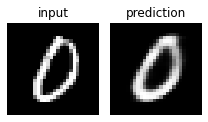

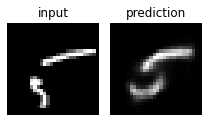

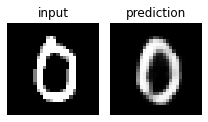

In [4]:
autoencoder.to('cpu')
for _ in range(3):
    ix = np.random.randint(len(test_data))
    im, _ = test_data[ix]
    _im= autoencoder(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

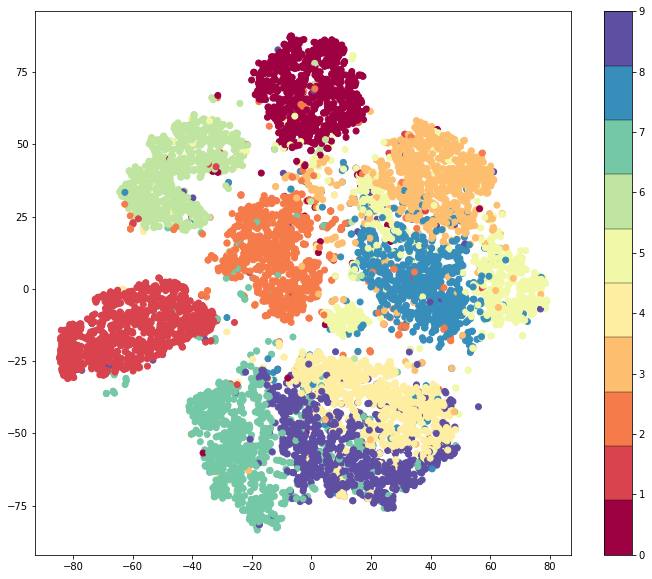

In [5]:
from sklearn.manifold import TSNE
latent_vectors = []
classes = []
for im,clss in test_dataloader:
    latent_vectors.append(autoencoder.encoder(im).view(len(im),-1))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
clustered = tsne.fit_transform(latent_vectors)
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)